In [37]:
import os
import io
import json
import requests
import numpy as np
import pandas as pd

# Fetching Data

In [ ]:
# Helper Functions


def fetch_stock_data(ticker, start_date, end_date=None):
    '''
    Fetchs end of day stock price data.
    
    :param ticker: string, stock ticker
    :param start_date: string, date to start collecting data at, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    
    ---> DataFrame, 
    '''
    api_key = get_api_key(source)
    if source == 'alphavantage':
        url = 'https://www.alphavantage.co/query'
        params = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': ticker, 'datatype': 'csv',
                  'apikey': api_keys['alphavantage'], 'outputsize': 'full'}
        

    

In [38]:
project_dir = os.path.split(os.getcwd())[0]
path_to_data = os.path.join(project_dir, 'data')

In [39]:
# Loading API keys
path_to_keys = os.path.join(project_dir, 'api_keys.json')
with open(path_to_keys, 'r') as f:
    api_keys = json.load(f)

In [40]:
ticker = 'INTC'
CIK = '0000050863'

## Fetching stock price data

In [41]:
# Stock price url and params
# url = 'https://www.quandl.com/api/v3/datasets/EOD/INTC.csv'
aa_url = 'https://www.alphavantage.co/query'
aa_params = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 'symbol': ticker, 'datatype': 'csv',
             'apikey': api_keys['alphavantage'], 'outputsize': 'full'}


In [42]:
# Accessing data
aa_response = requests.get(aa_url, params=aa_params)
with open(os.path.join(path_to_data, 'raw_TS_prices.csv'), 'w') as f:
    f.write(aa_response.text)

In [43]:
# inspecting data
price_df = pd.read_csv(os.path.join(path_to_data, 'raw_TS_prices.csv'), parse_dates=['timestamp'])
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 9 columns):
timestamp            5033 non-null datetime64[ns]
open                 5033 non-null float64
high                 5033 non-null float64
low                  5033 non-null float64
close                5033 non-null float64
adjusted_close       5033 non-null float64
volume               5033 non-null int64
dividend_amount      5033 non-null float64
split_coefficient    5033 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 354.0 KB


In [44]:
price_df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-09-20,51.60,51.88,50.60,50.72,50.72,22055333,0.0,1.0
1,2019-09-19,51.70,51.99,51.50,51.57,51.57,11428400,0.0,1.0
2,2019-09-18,52.13,52.13,51.16,51.74,51.74,14906800,0.0,1.0
3,2019-09-17,52.05,52.14,51.35,51.95,51.95,19641100,0.0,1.0
4,2019-09-16,51.90,52.29,51.70,52.20,52.20,13354600,0.0,1.0


In [45]:
# data need from time series to fetch text data
start_date = price_df.timestamp.min()
print(start_date)

1999-09-21 00:00:00


## Fetching text data

In [46]:
import re
import datetime
import lxml
from bs4 import BeautifulSoup

In [47]:
edgar_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
edgar_params = {'action': 'getcompany', 'CIK': CIK, 'type': '8-k',
                'owner': 'exclude', 'count': '100', 'output': 'atom', 'start': ''}

In [48]:
edgar_response = requests.get(edgar_url, params=edgar_params)
print(edgar_response.url)

https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000050863&type=8-k&owner=exclude&count=100&output=atom&start=


In [49]:
# Parsing initial response to build list of document urls and filing dates

soup = BeautifulSoup(edgar_response.text, 'lxml')

all_docs = []
# While the link to the next page existing is true
while True:
    # Find all document entries on the page
    entries = soup.find_all('entry')
    # For each entry scrape the filing-date and the url to the text document
    for entry in entries:
        filing_date = entry.find('filing-date').text
        doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
        doc_entry = (filing_date, doc_link)
        all_docs.append(doc_entry)
    # Break loop after scraping entries on the current page, but before requesting on the link to the next page which is potentially none existant
    if soup.find_all('link', {'rel': 'next'}) == []:
        break
    # Find link to the next page, request next page, and update soup object to consist of the next page
    nxt_pg_link = soup.find_all('link', {'rel': 'next'})[0]['href']
    nxt_pg = requests.get(nxt_pg_link)
    soup = BeautifulSoup(nxt_pg.text, 'lxml')

In [50]:
doc_df = pd.DataFrame(all_docs, columns=['filing_date', 'doc_loc'])
doc_df['filing_date'] = pd.to_datetime(doc_df['filing_date'])
doc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
filing_date    335 non-null datetime64[ns]
doc_loc        335 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 5.4+ KB


In [51]:
doc_df.head()

,filing_date,doc_loc
0,2019-09-13,https://www.sec.gov/Archives/edgar/data/50863/...
1,2019-07-25,https://www.sec.gov/Archives/edgar/data/50863/...
2,2019-05-22,https://www.sec.gov/Archives/edgar/data/50863/...
3,2019-05-09,https://www.sec.gov/Archives/edgar/data/50863/...
4,2019-04-25,https://www.sec.gov/Archives/edgar/data/50863/...


## Cleaning and Saving Data to Disk

In [52]:
# Helper Functions

def save_doc(url, endpoint):
    '''
    Downloads and saves the text file stored at :param url:, and saves it as its downloaded name in directory
    :param endpoint:.
    
    :param url: String, the url that points to the SEC text file
    :parame endpoint: String, path to location to save SEC filing
    
    ---> String, path to saved document
    '''
    r = requests.get(url)
    fname = url.split('/')[-1]
    with open(os.path.join(endpoint, fname), 'w') as f:
        f.write(r.text)
    return os.path.join(endpoint, fname)

### Merging dataframes

In [142]:
df = price_df.merge(doc_df, how='outer', left_on='timestamp', right_on='filing_date')

Checking if dataframes were merged properly.

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5059 entries, 0 to 5058
Data columns (total 11 columns):
timestamp            5043 non-null datetime64[ns]
open                 5043 non-null float64
high                 5043 non-null float64
low                  5043 non-null float64
close                5043 non-null float64
adjusted_close       5043 non-null float64
volume               5043 non-null float64
dividend_amount      5043 non-null float64
split_coefficient    5043 non-null float64
filing_date          335 non-null datetime64[ns]
doc_loc              335 non-null object
dtypes: datetime64[ns](2), float64(8), object(1)
memory usage: 474.3+ KB


In [144]:
df.head(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
0,2019-09-20,51.60,51.88,50.60,50.72,50.72,22055333.0,0.0,1.0,NaT,NaN
1,2019-09-19,51.70,51.99,51.50,51.57,51.57,11428400.0,0.0,1.0,NaT,NaN
2,2019-09-18,52.13,52.13,51.16,51.74,51.74,14906800.0,0.0,1.0,NaT,NaN
3,2019-09-17,52.05,52.14,51.35,51.95,51.95,19641100.0,0.0,1.0,NaT,NaN
4,2019-09-16,51.90,52.29,51.70,52.20,52.20,13354600.0,0.0,1.0,NaT,NaN
5,2019-09-13,52.76,53.00,52.23,52.54,52.54,18010800.0,0.0,1.0,2019-09-13,https://www.sec.gov/Archives/edgar/data/50863/...
6,2019-09-12,53.00,53.33,52.07,53.01,53.01,23308700.0,0.0,1.0,NaT,NaN
7,2019-09-11,51.60,52.79,51.38,52.79,52.79,18968900.0,0.0,1.0,NaT,NaN
8,2019-09-10,51.33,51.84,50.83,51.82,51.82,18532000.0,0.0,1.0,NaT,NaN
9,2019-09-09,51.06,52.03,51.02,51.59,51.59,20749700.0,0.0,1.0,NaT,NaN


In [145]:
df.tail(20)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
5039,1999-09-24,37.594,38.063,36.313,37.836,24.4907,124564000.0,0.0,1.0,NaT,NaN
5040,1999-09-23,41.563,41.594,38.250,38.750,25.0824,73686000.0,0.0,1.0,NaT,NaN
5041,1999-09-22,41.156,41.844,40.688,41.406,26.8017,42055400.0,0.0,1.0,NaT,NaN
5042,1999-09-21,41.875,41.875,40.969,41.000,26.5387,38608600.0,0.0,1.0,NaT,NaN
5043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-04-21,https://www.sec.gov/Archives/edgar/data/50863/...
5044,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-08-10,https://www.sec.gov/Archives/edgar/data/50863/...
5045,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-14,https://www.sec.gov/Archives/edgar/data/50863/...
5046,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-07-08,https://www.sec.gov/Archives/edgar/data/50863/...
5047,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-04-14,https://www.sec.gov/Archives/edgar/data/50863/...
5048,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-03-12,https://www.sec.gov/Archives/edgar/data/50863/...


### Cleaning Data

In [146]:
df.dropna(subset=['timestamp'], inplace=True)

Checking if data was cleaned properly.

In [147]:
df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
5038,1999-09-27,38.344,39.875,37.875,39.094,25.3049,71235400.0,0.0,1.0,NaT,NaN
5039,1999-09-24,37.594,38.063,36.313,37.836,24.4907,124564000.0,0.0,1.0,NaT,NaN
5040,1999-09-23,41.563,41.594,38.250,38.750,25.0824,73686000.0,0.0,1.0,NaT,NaN
5041,1999-09-22,41.156,41.844,40.688,41.406,26.8017,42055400.0,0.0,1.0,NaT,NaN
5042,1999-09-21,41.875,41.875,40.969,41.000,26.5387,38608600.0,0.0,1.0,NaT,NaN


### Saving data to disk

In [125]:
# Downloading and saving SEC files to disk and modifying doc_loc
df['doc_loc'] = df['doc_loc'].map(lambda url: save_doc(url, os.path.join(path_to_data, 'documents')) if not pd.isnull(url) else np.nan)
df.head(10)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc
0,2019-09-20,51.60,51.88,50.60,50.72,50.72,22055333.0,0.0,1.0,NaT,NaN
1,2019-09-19,51.70,51.99,51.50,51.57,51.57,11428400.0,0.0,1.0,NaT,NaN
2,2019-09-18,52.13,52.13,51.16,51.74,51.74,14906800.0,0.0,1.0,NaT,NaN
3,2019-09-17,52.05,52.14,51.35,51.95,51.95,19641100.0,0.0,1.0,NaT,NaN
4,2019-09-16,51.90,52.29,51.70,52.20,52.20,13354600.0,0.0,1.0,NaT,NaN
5,2019-09-13,52.76,53.00,52.23,52.54,52.54,18010800.0,0.0,1.0,2019-09-13,/media/Data/Programs/FinTech/data/documents/00...
6,2019-09-12,53.00,53.33,52.07,53.01,53.01,23308700.0,0.0,1.0,NaT,NaN
7,2019-09-11,51.60,52.79,51.38,52.79,52.79,18968900.0,0.0,1.0,NaT,NaN
8,2019-09-10,51.33,51.84,50.83,51.82,51.82,18532000.0,0.0,1.0,NaT,NaN
9,2019-09-09,51.06,52.03,51.02,51.59,51.59,20749700.0,0.0,1.0,NaT,NaN


In [126]:
# Saving modified dataframe to disk
df.to_csv(os.path.join(path_to_data, 'raw.csv'), index=False)

## Exploratory Data Analysis

In [150]:
import matplotlib.pyplot as plt

In [151]:
# Helper Functions

def plot_col(col, title, xl, yl):
    xy = df[col].dropna()
    xy.index = len(xy.index) - 1 - xy.index
    fig, ax = plt.subplots()
    ax.plot(xy.index, xy[xy.index])
    ax.set_title(title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    return None

see if there is any correlation between the release date of an 8k form and change in yield

In [161]:
# Loading DataFrame from disk
df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp', 'filing_date'])
#df.index = list(df.index)
#df.index = len(df.index) - 1 - df.index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 11 columns):
timestamp            5043 non-null datetime64[ns]
open                 5043 non-null float64
high                 5043 non-null float64
low                  5043 non-null float64
close                5043 non-null float64
adjusted_close       5043 non-null float64
volume               5043 non-null float64
dividend_amount      5043 non-null float64
split_coefficient    5043 non-null float64
filing_date          319 non-null datetime64[ns]
doc_loc              319 non-null object
dtypes: datetime64[ns](2), float64(8), object(1)
memory usage: 433.5+ KB


In [162]:
df.describe()

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5.043000e+03,5043.000000,5043.000000
mean,29.131107,29.521620,28.744994,29.127541,22.899412,4.970096e+07,0.002394,1.000198
std,11.209456,11.398641,11.034131,11.209550,10.917856,2.625357e+07,0.022497,0.014082
min,12.170000,12.630000,12.050000,12.080000,8.615100,1.155400e+06,0.000000,1.000000
25%,21.220000,21.450000,21.004450,21.210000,15.253600,2.968790e+07,0.000000,1.000000
50%,25.850000,26.140000,25.570000,25.880000,18.702400,4.709750e+07,0.000000,1.000000
75%,34.190000,34.548500,33.750000,34.205000,28.958000,6.312485e+07,0.000000,1.000000
max,75.625000,75.828000,73.625000,74.875000,58.069900,3.093476e+08,0.315000,2.000000


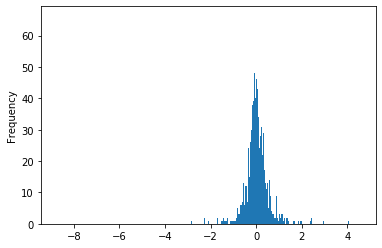

In [163]:
df['daily_returns'] = df['adjusted_close'].shift(1) - df['adjusted_close']
df['daily_returns'].plot.hist(bins=2000)
# appears normally distributed?

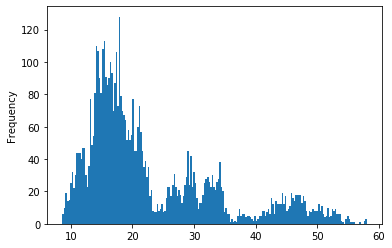

In [164]:
df.adjusted_close.dropna().plot.hist(bins=200) # lognormal

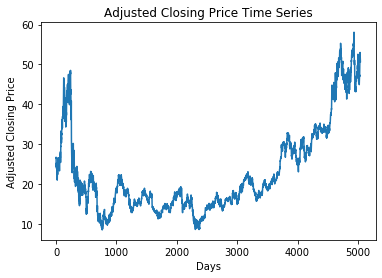

In [165]:
plot_col('adjusted_close', 'Adjusted Closing Price Time Series', 'Days', 'Adjusted Closing Price')

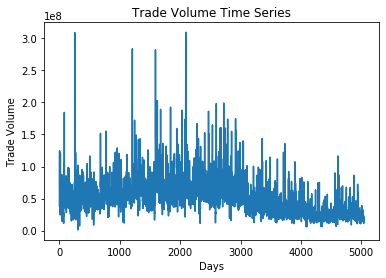

In [166]:
plot_col('volume', 'Trade Volume Time Series', 'Days', 'Trade Volume')

# Feature Selection and Encoding

using only daily returns and documents

In [170]:
# Helper Functions

def to_time_series(df, columns, n_trail=1, n_lead=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(n_trail, 0, -1):
        dfs.append(df.shift(-i))
        col_names += [(col_name + '(t-{})'.format(i)) for col_name in columns]
        
    # Create leading columns
    for i in range(0, n_lead+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t+{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    #agg.dropna(inplace=True)
    
    return agg
    

In [171]:
col = ['daily_returns', 'doc_loc', 'timestamp']
reframed = to_time_series(df, col, n_trail=5, n_lead=1)
reframed.head(10)

,daily_returns(t-5),doc_loc(t-5),timestamp(t-5),daily_returns(t-4),doc_loc(t-4),timestamp(t-4),daily_returns(t-3),doc_loc(t-3),timestamp(t-3),daily_returns(t-2),...,timestamp(t-2),daily_returns(t-1),doc_loc(t-1),timestamp(t-1),daily_returns(t+0),doc_loc(t+0),timestamp(t+0),daily_returns(t+1),doc_loc(t+1),timestamp(t+1)
0,-0.34,/media/Data/Programs/FinTech/data/documents/00...,2019-09-13,-0.25,NaN,2019-09-16,-0.21,NaN,2019-09-17,-0.17,...,2019-09-18,-0.85,NaN,2019-09-19,NaN,NaN,2019-09-20,NaN,NaN,NaT
1,-0.47,NaN,2019-09-12,-0.34,/media/Data/Programs/FinTech/data/documents/00...,2019-09-13,-0.25,NaN,2019-09-16,-0.21,...,2019-09-17,-0.17,NaN,2019-09-18,-0.85,NaN,2019-09-19,NaN,NaN,2019-09-20
2,0.22,NaN,2019-09-11,-0.47,NaN,2019-09-12,-0.34,/media/Data/Programs/FinTech/data/documents/00...,2019-09-13,-0.25,...,2019-09-16,-0.21,NaN,2019-09-17,-0.17,NaN,2019-09-18,-0.85,NaN,2019-09-19
3,0.97,NaN,2019-09-10,0.22,NaN,2019-09-11,-0.47,NaN,2019-09-12,-0.34,...,2019-09-13,-0.25,NaN,2019-09-16,-0.21,NaN,2019-09-17,-0.17,NaN,2019-09-18
4,0.23,NaN,2019-09-09,0.97,NaN,2019-09-10,0.22,NaN,2019-09-11,-0.47,...,2019-09-12,-0.34,/media/Data/Programs/FinTech/data/documents/00...,2019-09-13,-0.25,NaN,2019-09-16,-0.21,NaN,2019-09-17
5,0.67,NaN,2019-09-06,0.23,NaN,2019-09-09,0.97,NaN,2019-09-10,0.22,...,2019-09-11,-0.47,NaN,2019-09-12,-0.34,/media/Data/Programs/FinTech/data/documents/00...,2019-09-13,-0.25,NaN,2019-09-16
6,0.82,NaN,2019-09-05,0.67,NaN,2019-09-06,0.23,NaN,2019-09-09,0.97,...,2019-09-10,0.22,NaN,2019-09-11,-0.47,NaN,2019-09-12,-0.34,/media/Data/Programs/FinTech/data/documents/00...,2019-09-13
7,1.18,NaN,2019-09-04,0.82,NaN,2019-09-05,0.67,NaN,2019-09-06,0.23,...,2019-09-09,0.97,NaN,2019-09-10,0.22,NaN,2019-09-11,-0.47,NaN,2019-09-12
8,1.94,NaN,2019-09-03,1.18,NaN,2019-09-04,0.82,NaN,2019-09-05,0.67,...,2019-09-06,0.23,NaN,2019-09-09,0.97,NaN,2019-09-10,0.22,NaN,2019-09-11
9,-0.43,NaN,2019-08-30,1.94,NaN,2019-09-03,1.18,NaN,2019-09-04,0.82,...,2019-09-05,0.67,NaN,2019-09-06,0.23,NaN,2019-09-09,0.97,NaN,2019-09-10


In [173]:
df.head(6)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,filing_date,doc_loc,daily_returns
0,2019-09-20,51.60,51.88,50.60,50.72,50.72,22055333.0,0.0,1.0,NaT,NaN,NaN
1,2019-09-19,51.70,51.99,51.50,51.57,51.57,11428400.0,0.0,1.0,NaT,NaN,-0.85
2,2019-09-18,52.13,52.13,51.16,51.74,51.74,14906800.0,0.0,1.0,NaT,NaN,-0.17
3,2019-09-17,52.05,52.14,51.35,51.95,51.95,19641100.0,0.0,1.0,NaT,NaN,-0.21
4,2019-09-16,51.90,52.29,51.70,52.20,52.20,13354600.0,0.0,1.0,NaT,NaN,-0.25
5,2019-09-13,52.76,53.00,52.23,52.54,52.54,18010800.0,0.0,1.0,2019-09-13,/media/Data/Programs/FinTech/data/documents/00...,-0.34
